In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz


import pandas as pd
from plotnine import *

import networkx as nx
import strat_models
import statsmodels.api as sm

C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
dim = 25
n = 500
rho = 0.3
sigma = 1/4
K = 400

In [3]:
def GaussianKernel(d,h):
    return np.exp(-(d)**2/(2*h**2))
def ExpKernel(d,h):
    return np.exp(-d/(2*h))
def BoxCarKernel(d,h):
    if d >= h:
        return 0
    else:
        return 1
def BiSquareKernel(d,h):
    if d >= h:
        return 0
    else:
        return (1-(d/h)**2)**2

kernels = [GaussianKernel,ExpKernel,BoxCarKernel,BiSquareKernel]

In [4]:
def generate_data(n,dim,cor):
    cov_values = [cor**k for k in range(dim)]
    cov_matrix = toeplitz(cov_values)

    sample = np.random.multivariate_normal(mean=[0]*dim,cov=cov_matrix,size=n)
    return sample

def get_coefs(x,dim):
    return np.sin(x/2)*np.ones(dim)

### One simulation

In [5]:
param_number = 0
n=500
# Generate all of the data
h = np.reshape(np.random.uniform(low=0,high=13,size=n),newshape=(n,1))
h.sort(axis=0)
X = generate_data(n,dim,rho)
coefs = get_coefs(h,dim)

Y = np.diag(X@coefs.T)+sigma*np.random.randn(n)
Y = np.reshape(Y,(n,1))


# GWLS
results = pd.DataFrame(columns=["Method","h","paramEstimation"])
kernel_names = ["Gaussian","Exponential","Box-Car","BiSquare"]
kernel_bandwidths = [0.414,0.135,0.962,1.19]
for kernel_index in range(len(kernel_names)):
        GWLS_b = kernel_bandwidths[kernel_index]
        GWLS_params = []
        for current_h in h:
            weights = []
            for i in range(len(h)):
                weights.append(kernels[kernel_index](np.abs((current_h-h[i]))[0],GWLS_b))

            res = sm.WLS(Y,X,weights).fit()
            results.loc[len(results)] = [kernel_names[kernel_index],current_h[0],res.params[param_number]]


# Variable binning
K = 400
label = np.zeros(len(Y))
stops = np.linspace(0,13,K)[1:]
for i in range(len(Y)):
    label[i] = (stops>h[i]).argmax()
dat_train = dict(X=X, Y=Y, Z=label)
W = 70.25
bin_graph = nx.path_graph(K) 
strat_models.set_edge_weight(bin_graph,W)

base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))
mod = strat_models.StratifiedModel(base, graph=bin_graph)
mod.fit(dat_train)
for i in range(len(h)):
    results.loc[len(results)] = ["Stratified",h[i][0],mod.G.nodes[label[i]]["theta"][param_number][0]]

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\strat_models\losses.py:153: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:1822: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2002.)
c:\Users\thoma\AppData\Local\Programs\Py

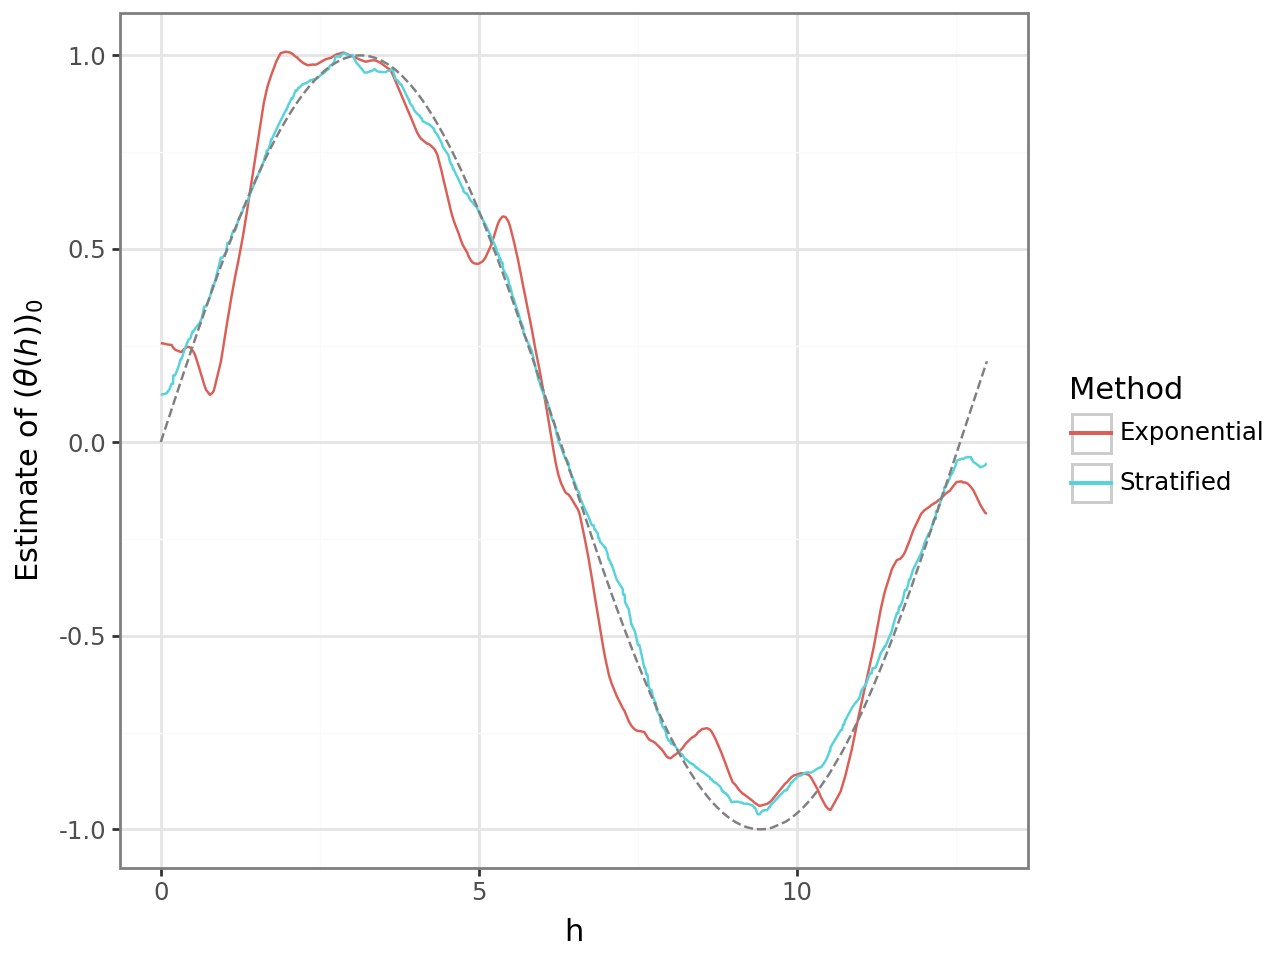

In [6]:
results["true"] = np.sin(results["h"]/2)
plot = ggplot(results[(results["Method"] == "Stratified")|(results["Method"] == "Exponential")])+aes(x="h",y="paramEstimation",color="Method")+geom_line()+geom_line(aes(x="h",y="true"),color="gray",linetype = "dashed")+theme_bw()
plot = plot+labs(y=r"Estimate of $\left(\theta(h)\right)_0$")
plot

### Pointwise Bias and Variance

In [7]:
results = pd.DataFrame(columns=["Method","h","paramEstimation"])

In [8]:
n=500
absc = np.linspace(0,13,50)

for i in range(50):
    # Generate all of the data
    h = np.reshape(np.random.uniform(low=0,high=13,size=n),newshape=(n,1))
    h.sort(axis=0)
    X = generate_data(n,dim,rho)
    coefs = get_coefs(h,dim)

    Y = np.diag(X@coefs.T)+sigma*np.random.randn(n)
    Y = np.reshape(Y,(n,1))
    # GWLS
    kernel_names = ["Gaussian","Exponential","Box-Car","BiSquare"]
    kernel_bandwidths = [0.414,0.135,0.962,1.19]
    for kernel_index in range(len(kernel_names)):
            GWLS_b = kernel_bandwidths[kernel_index]
            GWLS_params = []
            for current_h in absc:
                weights = []
                for i in range(len(h)):
                    weights.append(kernels[kernel_index](np.abs((current_h-h[i]))[0],GWLS_b))

                res = sm.WLS(Y,X,weights).fit()
                results.loc[len(results)] = [kernel_names[kernel_index],current_h,res.params[param_number]]


    # Variable binning
    K = 400
    label_train = np.zeros(len(Y))
    label_predict = np.zeros(len(absc))

    stops = np.linspace(0,13,K)[1:]
    for i in range(len(Y)):
        label_train[i] = (stops>h[i]).argmax()
    for i in range(len(absc)):
        label_predict[i] = (stops>absc[i]).argmax()

    dat_train = dict(X=X, Y=Y, Z=label_train)
    W = 70.25
    bin_graph = nx.path_graph(K) 
    strat_models.set_edge_weight(bin_graph,W)

    base = strat_models.BaseModel(loss=strat_models.sum_squares_loss(intercept=False))
    mod = strat_models.StratifiedModel(base, graph=bin_graph)
    mod.fit(dat_train)
    for i in range(len(absc)):
        results.loc[len(results)] = ["LRSM",absc[i],mod.G.nodes[label_predict[i]]["theta"][param_number][0]]


In [9]:
df_res = results.groupby(by=["h","Method"]).agg([lambda x:np.mean(x),lambda x:np.round(np.mean(x)-1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.round(np.mean(x)+1.96*np.std(x)/np.sqrt(len(x)),3),lambda x:np.var(x)])
df_res.columns = ["Pred - Mean","Pred - lo","Pred - high","Variance"]
df_res = df_res.reset_index()
df_res["true"] = np.sin(df_res["h"]/2)
df_res

,h,Method,Pred - Mean,Pred - lo,Pred - high,Variance,true
0,0.0,BiSquare,0.293088,0.218,0.368,0.073077,0.00000
1,0.0,Box-Car,0.265078,0.175,0.355,0.105275,0.00000
2,0.0,Exponential,0.297625,0.222,0.373,0.074665,0.00000
3,0.0,Gaussian,0.288322,0.216,0.361,0.068650,0.00000
4,0.0,LRSM,0.225986,0.178,0.274,0.030402,0.00000
...,...,...,...,...,...,...,...
245,13.0,BiSquare,-0.016995,-0.086,0.052,0.061434,0.21512
246,13.0,Box-Car,-0.046574,-0.122,0.029,0.074540,0.21512
247,13.0,Exponential,-0.021915,-0.096,0.052,0.071719,0.21512
248,13.0,Gaussian,-0.014902,-0.083,0.054,0.061231,0.21512


In [10]:
df_res["Bias"] = df_res["Pred - Mean"]-df_res["true"]
df_res["Bias Lo"] = df_res["Pred - lo"]-df_res["true"]
df_res["Bias Hi"] = df_res["Pred - high"]-df_res["true"]

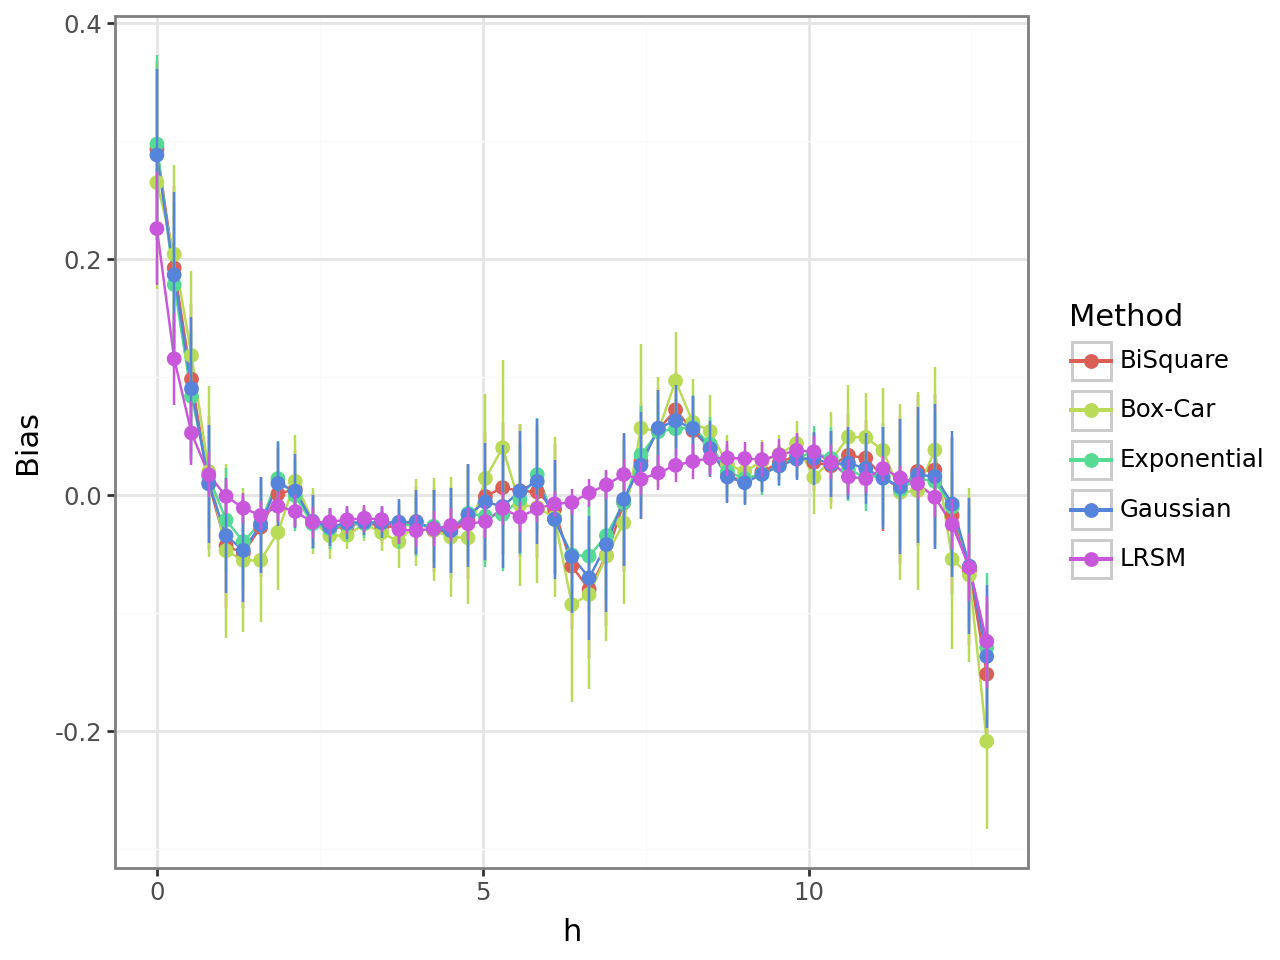

In [11]:
plot = ggplot(df_res[df_res.h<13])+aes(x="h",y="Bias",ymin = "Bias Lo",ymax = "Bias Hi",color="Method",group="Method")+geom_line()+theme_bw()+geom_pointrange()
plot

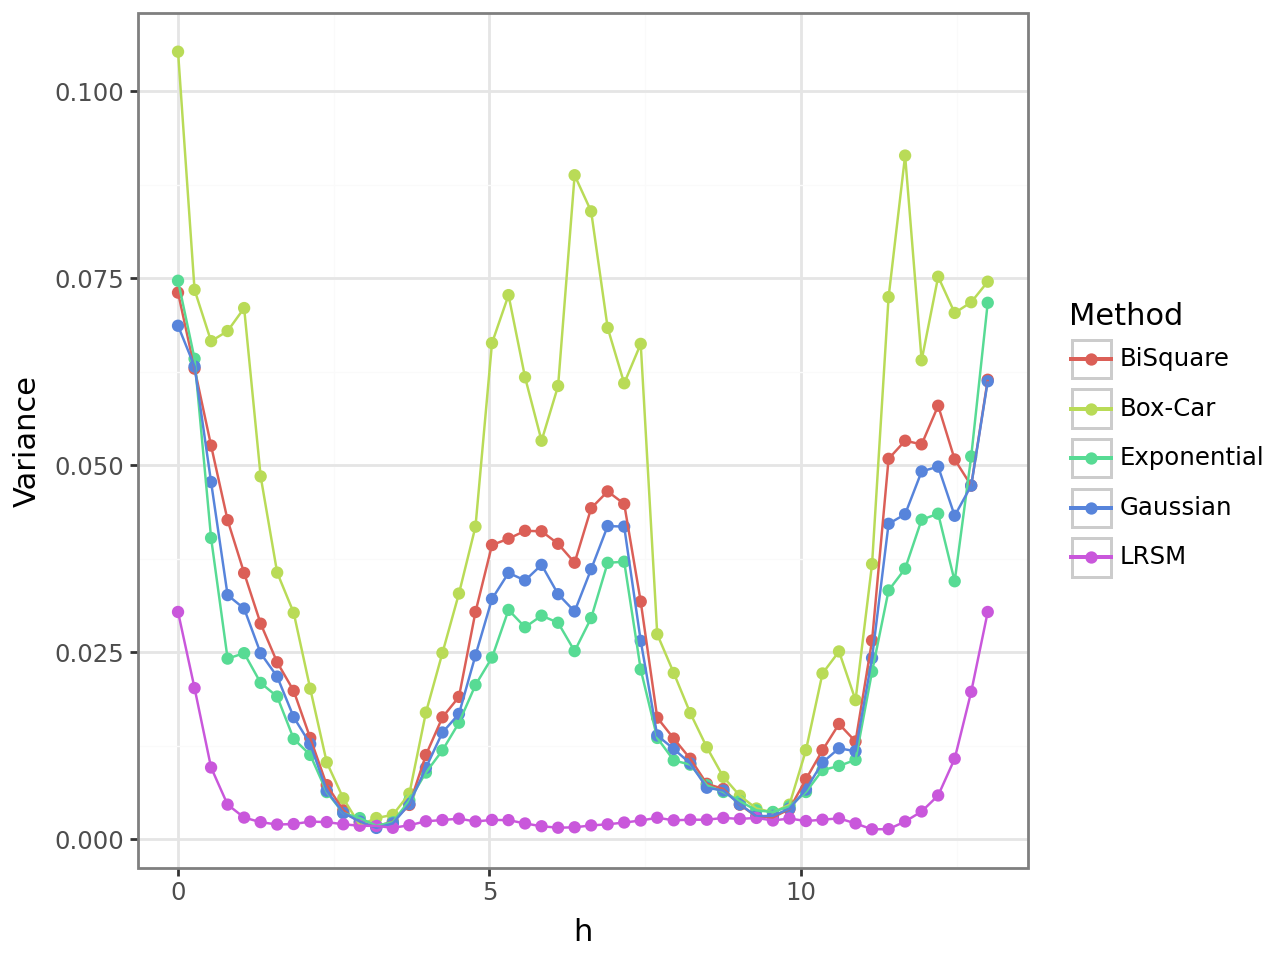

In [12]:
plot = ggplot(df_res)+aes(x="h",y="Variance",color="Method",group="Method")+geom_point()+geom_line()+theme_bw()
plot